# Análisis factorial para MCGM versión niños 

Este análisis compromete la exploración de una base de datos recogida por el equipo del proyecto de gratitude de la Universidad e los Andes. Vamos a hacer un análisis psicomético de la base de datos y ver si ódemos replicar el modelo propuesto por Morgan y colaboradores en 2017 para explorar la gratitud como una virtud moral. 

<a id ='inicio'></a>

Tabla de contenidos

<a href='#base'> Cargar base de datos </a>

<a href='#corr1'> Correlación de ítems </a>

<a href='#supuestos'> Verificación de supuestos </a>

<a href='#num_factor'> Elección de número de factores </a>

<a href='#cfa'> Análisis factorial confirmatorio </a>

<a href='#cronbach'> Alfa de Cronbach </a>

<a href='#descriptivos'> Algunos descriptivos </a>

In [77]:
import pingouin as pg
import pandas as pd
import numpy as np
from numpy import pi, diff
import matplotlib.pyplot as plt
from scipy.stats import circstd, sem, chi2, pearsonr,norm, ttest_ind,  vonmises, circmean, circvar, zscore, binom, beta, t, linregress, shapiro, normaltest
from math import cos,sin, atan2,radians,degrees, factorial
from scipy import stats
import seaborn as sns
from cycler import cycler
from statsmodels.formula.api import ols
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

from factor_analyzer.utils import (corr,
                                   impute_values,
                                   partial_correlations,
                                   smc)
import scipy.spatial.distance as dist
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [157]:
POSSIBLE_IMPUTATIONS = ['mean', 'median', 'drop']

POSSIBLE_METHODS = ['ml', 'mle', 'uls', 'minres', 'principal']

from factor_analyzer.factor_analyzer import calculate_kmo

def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha


def percentage_of_area_under_std_normal_curve_from_zcore(z_score):
    return .5 * (math.erf(z_score / 2 ** .5) + 1)

def calculate_kmo(x):
    """
    Calculate the Kaiser-Meyer-Olkin criterion
    for items and overall. This statistic represents
    the degree to which each observed variable is
    predicted, without error, by the other variables
    in the dataset. In general, a KMO < 0.6 is considered
    inadequate.

    Parameters
    ----------
    x : array-like
        The array from which to calculate KMOs.

    Returns
    -------
    kmo_per_variable : numpy array
        The KMO score per item.
    kmo_total : float
        The KMO score overall.
    """

    # calculate the partial correlations
    partial_corr = partial_correlations(x)

    # calcualte the pair-wise correlations
    x_corr = corr(x)

    # fill matrix diagonals with zeros
    # and square all elements
    np.fill_diagonal(x_corr, 0)
    np.fill_diagonal(partial_corr, 0)

    partial_corr = partial_corr**2
    x_corr = x_corr**2

    # calculate KMO per item
    partial_corr_sum = np.sum(partial_corr, axis=0)
    corr_sum = np.sum(x_corr, axis=0)
    kmo_per_item = corr_sum / (corr_sum + partial_corr_sum)

    # calculate KMO overall
    corr_sum_total = np.sum(x_corr)
    partial_corr_sum_total = np.sum(partial_corr)
    kmo_total = corr_sum_total / (corr_sum_total + partial_corr_sum_total)
    return kmo_per_item, kmo_total



def calculate_bartlett_sphericity(x):
    """
    Test the hypothesis that the correlation matrix
    is equal to the identity matrix.identity

    H0: The matrix of population correlations is equal to I.
    H1: The matrix of population correlations is not equal to I.

    The formula for Bartlett's Sphericity test is:

    .. math:: -1 * (n - 1 - ((2p + 5) / 6)) * ln(det(R))

    Where R det(R) is the determinant of the correlation matrix,
    and p is the number of variables.

    Parameters
    ----------
    x : array-like
        The array from which to calculate sphericity.

    Returns
    -------
    statistic : float
        The chi-square value.
    p_value : float
        The associated p-value for the test.
    """
    n, p = x.shape
    x_corr = corr(x)

    corr_det = np.linalg.det(x_corr)
    statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
    degrees_of_freedom = p * (p - 1) / 2
    p_value = chi2.sf(statistic, degrees_of_freedom)
    return statistic, p_value

def csv_download_link(df, csv_file_name, delete_prompt=True):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink
    display(FileLink(csv_file_name))
    if delete_prompt:
        a = input('Press enter to delete the file after you have downloaded it.')
        import os
        os.remove(csv_file_name)
        
def bootstrap(data, estimator=np.mean, summary=np.std, nsamples=2000):
    n = len(data)
    samples = [estimator(data[np.random.randint(n, size=n)])
               for _ in range(nsamples)]
    return summary(samples)

def sem(sd, n):
    se = sd /np.sqrt(n)
    return se

def ci95 (mean, sem, z=1.960):
    low = mean - z*sem
    high = mean + z*sem
    return [low, high]

#for dataset

def ci951 (data, z=1.960):
    sem1 = np.nanstd(data)/np.sqrt(len(data))
    mean = np.nanmean(data)
    low = mean - z*sem1
    high = mean + z*sem1
    return [low, high]


<a id ='base'></a>

# Load data

In [23]:
#df = pd.read_csv('base_final1.csv', sep=",")
df = pd.read_csv('RESCALADO.csv', sep = ",", encoding='latin-1')

In [24]:
# df['nino_nina']= df['Q8'].replace({1: 'niño', 2: 'niña'})

In [25]:
df.columns

Index(['Q1', 'Q2', 'MCGM_1', 'MCGM_2', 'MCGM_3', 'MCGM_4', 'MCGM_5', 'MCGM_6',
       'MCGM_7', 'MCGM_8', 'MCGM_9', 'MCGM_10', 'MCGM_11', 'MCGM_12',
       'MCGM_13', 'MCGM_14', 'MCGM_15', 'MCGM_16', 'MCGM_17', 'MCGM_18',
       'MCGM_19', 'MCGM_20', 'MCGM_21', 'MCGM_22', 'MCGM_23', 'MCGM_24',
       'MCGM_25', 'MCGM_26', 'MCGM_27', 'MCGM_28', 'MCGM_29'],
      dtype='object')

In [26]:
df.drop(['Q1', 'Q2'],axis=1,inplace=True)

In [27]:
df.head()

,MCGM_1,MCGM_2,MCGM_3,MCGM_4,MCGM_5,MCGM_6,MCGM_7,MCGM_8,MCGM_9,MCGM_10,...,MCGM_20,MCGM_21,MCGM_22,MCGM_23,MCGM_24,MCGM_25,MCGM_26,MCGM_27,MCGM_28,MCGM_29
0,5,5,5,5,5,5,5,5,5,5,...,1,5,5,5,5,5,5,5,5,5
1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,4,5,4,4,4,4,1,4,4,4,...,4,2,2,2,2,2,2,2,2,2
3,5,5,5,5,5,5,5,5,5,5,...,1,2,1,5,5,5,5,5,5,5
4,5,4,5,4,5,5,5,5,5,5,...,2,4,2,4,4,5,5,5,5,5


<a href='#inicio'> Ir a inicio </a>

<a id ='corr1'></a>

# Scaling and correlations within items

Escalo la base de datos porque si no centro y escalo mis datos observador, la columnas que tiene mayor SD, tengan más 
influencia en el modelo y esto puede ser tan bueno como malo. Entonces prefiero escalarlo.

In [121]:
scale_MCGM = preprocessing.scale(X = df)

In [122]:
scale_MCGM = pd.DataFrame(data = scale_MCGM)

(29.1, -0.09999999999999998)

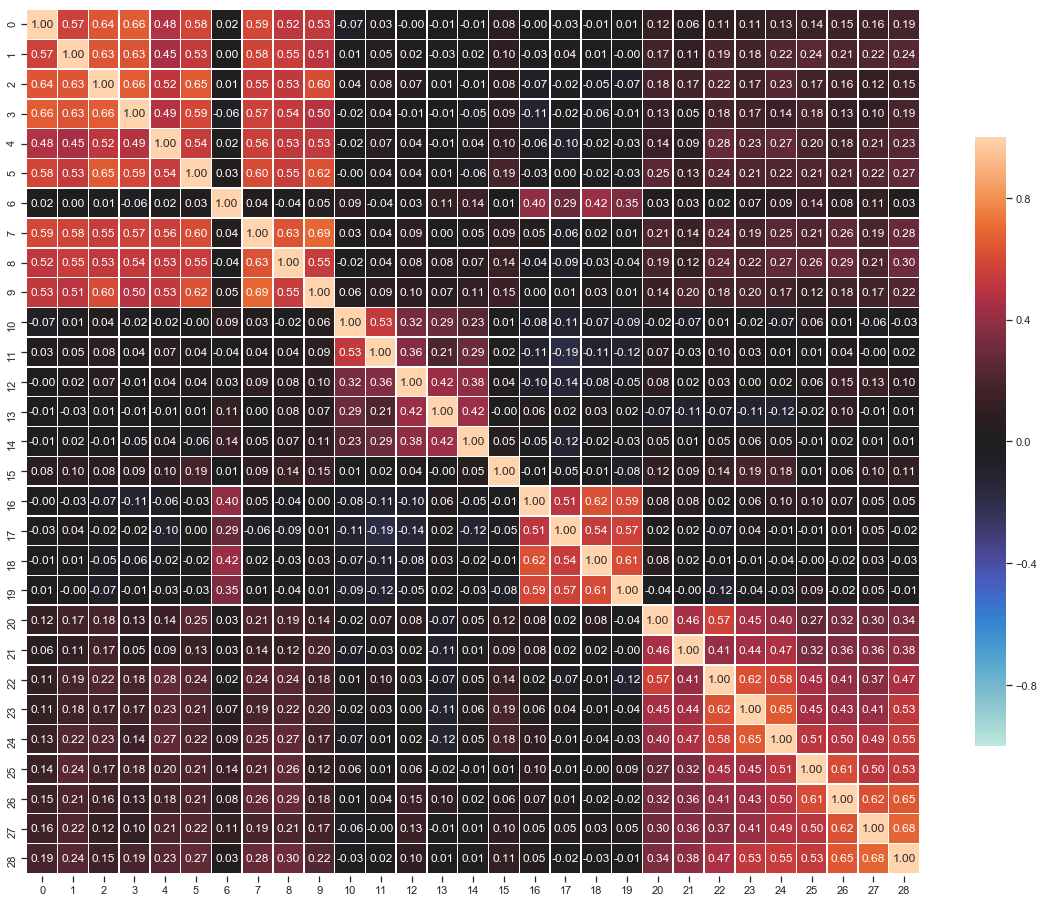

In [123]:
scale_MCGM.corr()

fig, ax = plt.subplots(figsize=(20,16))  
sns.heatmap(data = scale_MCGM.corr(), vmin=-1, vmax =1, center = 0, fmt='.2f', cbar_kws={"shrink": .7}, square = False, linewidths=.5, annot=True)
heatmap.set_title('Gratitude Heatmap', fontdict={'fontsize':17}, pad=12)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)

__P-values__

In [124]:
r_cors = scale_MCGM.corr()
mu_all = [np.nanmean(scale_MCGM[i]) for i in range(29)]
y = np.random.multivariate_normal(mu_all, r_cors, size=len(scale_MCGM))

In [75]:
df2 = pd.DataFrame(y)

In [78]:
display(df2.rcorr(method='spearman',padjust='holm'))
print('\n\n p-value: p < 0.05*, p < 0.01**, p < 0.001***')

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-,***,***,***,***,***,,***,***,***,...,,,,,,,,,,
1,0.578,-,***,***,***,***,,***,***,***,...,,**,,,,*,,,,
2,0.63,0.628,-,***,***,***,,***,***,***,...,,**,*,,,*,,,,
3,0.642,0.657,0.642,-,***,***,,***,***,***,...,,,,,,,,,,
4,0.468,0.482,0.489,0.52,-,***,,***,***,***,...,,,,**,,,,,,*
5,0.514,0.528,0.626,0.545,0.54,-,,***,***,***,...,,**,,,*,,,,**,**
6,-0.012,-0.019,-0.016,-0.084,-0.079,0.005,-,,,,...,***,,,,,,,,,
7,0.506,0.592,0.511,0.548,0.51,0.555,0.064,-,***,***,...,,,,*,**,**,,**,*,***
8,0.446,0.5,0.478,0.429,0.48,0.491,-0.015,0.519,-,***,...,,,,***,*,***,***,***,***,***
9,0.431,0.466,0.567,0.394,0.487,0.583,-0.057,0.672,0.469,-,...,,,,,,,,,,




 p-value: p < 0.05*, p < 0.01**, p < 0.001***


______________

<a href='#inicio'> Ir a inicio </a>

<a id ='supuestos'></a>

# Verificación de supuestos

__Bartlett’s test__

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [79]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(scale_MCGM)
print("Bartlett ’s test x2: ", chi_square_value, "p: ", p_value)

Bartlett ’s test x2:  4231.584129846744 p:  0.0


__Kaiser-Meyer-Olkin (KMO)__

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [80]:
kmo_all,kmo_model=calculate_kmo(scale_MCGM)

In [81]:
print("KMO: ", kmo_model)

KMO:  0.8731728103704419


<a href='#inicio'> Ir a inicio </a>

___________

<a id ='num_factor'></a>

# Choosing the Number of Factors

For choosing the number of factors, you can use the Kaiser criterion and scree plot. Both are based on eigenvalues.

In [82]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation="oblimin", method = "minres")

fa.fit(scale_MCGM, 29)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([6.98209688, 3.54932169, 3.03940063, 2.39401778, 1.25808992,
       1.04245191, 0.92117475, 0.83024881, 0.7127794 , 0.69999045,
       0.64881169, 0.62444974, 0.58176665, 0.55240276, 0.51027062,
       0.46653064, 0.4517623 , 0.40855251, 0.39504715, 0.37738446,
       0.3524123 , 0.34138823, 0.31214723, 0.30144713, 0.28625086,
       0.27019334, 0.25151015, 0.24416739, 0.19393264])

__Screeplot__

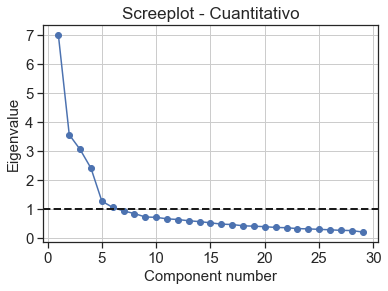

In [83]:
plt.scatter(range(1,scale_MCGM.shape[1]+1),ev)
plt.plot(range(1,scale_MCGM.shape[1]+1),ev)
plt.title('Screeplot - Cuantitativo', size = 17)
plt.xlabel('Component number', size = 15)
plt.ylabel('Eigenvalue', size = 15)
plt.axhline(y=1, color='k', linewidth=2, linestyle='--')
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.grid()

In [84]:
fa.get_communalities()

array([0.63580202, 0.53334432, 0.6556677 , 0.64628534, 0.41763848,
       0.58237831, 0.2078517 , 0.60407066, 0.48453285, 0.56656906,
       0.02818611, 0.06051464, 0.0389652 , 0.00555389, 0.01508845,
       0.03002062, 0.58604745, 0.49468918, 0.60954665, 0.59339938,
       0.29369161, 0.34040823, 0.49851699, 0.54607879, 0.59995657,
       0.43766379, 0.50553976, 0.47679824, 0.57366917])

__Elijo 5 factores para correr el PCA__ 

In [85]:
fa.set_params(n_factors=5, rotation='oblimin',  use_smc=True)
fa.fit(scale_MCGM)
loadings = fa.loadings_
np.shape(fa.loadings_)

(29, 5)

In [86]:
loadings

array([[ 7.90942868e-01,  9.66153198e-03,  2.59725106e-02,
        -1.15781485e-01, -6.34864733e-02],
       [ 7.29215588e-01,  1.48434715e-02,  6.89314024e-02,
        -3.07165081e-02, -2.43321510e-02],
       [ 8.06984815e-01, -2.60643489e-02, -1.11074747e-01,
         8.18768317e-02,  1.60988895e-02],
       [ 8.00794671e-01, -5.61191666e-02, -2.54047847e-02,
        -5.14672161e-02, -7.89397502e-02],
       [ 6.40708633e-01, -3.48044721e-02,  8.96923193e-03,
         8.56322980e-02,  1.08134255e-02],
       [ 7.62526978e-01,  7.49744986e-03,  7.70189330e-03,
         5.58075548e-02, -2.49311954e-02],
       [-7.97739046e-03,  5.03595670e-01,  5.62549154e-02,
         3.39226509e-02,  1.68542397e-01],
       [ 7.71828093e-01,  4.32115098e-02,  5.48412142e-02,
         9.46533155e-03,  4.22775023e-02],
       [ 6.86439983e-01, -4.13764684e-02,  1.34820400e-01,
        -1.42012659e-02,  3.94817511e-02],
       [ 7.47036335e-01,  7.13238368e-02, -5.64092833e-02,
         5.37154613e-02

In [87]:
# Get variance of each factors
fa.get_factor_variance()

(array([5.09044181, 2.59630624, 2.35686815, 2.29748195, 1.83498358]),
 array([0.17553248, 0.0895278 , 0.08127132, 0.07922352, 0.0632753 ]),
 array([0.17553248, 0.26506028, 0.34633159, 0.42555511, 0.4888304 ]))

In [88]:
print('Explained variance: ', sum(fa.get_factor_variance()[1])*100, '%')

Explained variance:  48.88304044104687 %


<a href='#inicio'> Ir a inicio </a>

_____

<a id ='cfa'></a>

# Confirmatory Factor Analysis

In [89]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer,
   ...:                              ModelSpecificationParser)

In [90]:
 model_dict = {"F1": ["MCGM_1", "MCGM_2", "MCGM_3", "MCGM_4", "MCGM_5", "MCGM_6", "MCGM_8", "MCGM_9", "MCGM_10"],
              "F3": ["MCGM_11", "MCGM_12", "MCGM_13", "MCGM_14", "MCGM_15", "MCGM_16"], 
              "F4": ["MCGM_7","MCGM_17", "MCGM_18", "MCGM_19", "MCGM_20"],
              "F5": ["MCGM_21", "MCGM_22", "MCGM_23", "MCGM_24", "MCGM_25"], 
              "F6": ["MCGM_26", "MCGM_27", "MCGM_28", "MCGM_29"]}

In [91]:
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(scale_MCGM, model_dict)

In [92]:
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False)

In [93]:
cfa.fit(scale_MCGM.values)

c:\users\maria\appdata\local\programs\python\python37-32\lib\site-packages\factor_analyzer\confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=311,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x217EDE30>,
                           tol=None)

In [94]:
cfa.loadings_

array([[1.01198582, 0.        , 0.        , 0.        , 0.        ],
       [0.99546076, 0.        , 0.        , 0.        , 0.        ],
       [1.03844469, 0.        , 0.        , 0.        , 0.        ],
       [1.02339911, 0.        , 0.        , 0.        , 0.        ],
       [0.92937339, 0.        , 0.        , 0.        , 0.        ],
       [1.01597464, 0.        , 0.        , 0.        , 0.        ],
       [0.49355291, 0.        , 0.        , 0.        , 0.        ],
       [1.01967615, 0.        , 0.        , 0.        , 0.        ],
       [0.97201544, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.71829375, 0.        , 0.        , 0.        ],
       [0.        , 0.93598244, 0.        , 0.        , 0.        ],
       [0.        , 0.94733433, 0.        , 0.        , 0.        ],
       [0.        , 0.97432683, 0.        , 0.        , 0.        ],
       [0.        , 0.92877197, 0.        , 0.        , 0.        ],
       [0.        , 0.93355073, 0.

In [95]:
cfa.factor_varcovs_

array([[1.        , 0.12388381, 0.05016693, 0.16063621, 0.17244124],
       [0.12388381, 1.        , 0.01766028, 0.04752353, 0.07114167],
       [0.05016693, 0.01766028, 1.        , 0.05461383, 0.05469944],
       [0.16063621, 0.04752353, 0.05461383, 1.        , 0.36702884],
       [0.17244124, 0.07114167, 0.05469944, 0.36702884, 1.        ]])

In [98]:
cfa.transform(scale_MCGM.values)

array([[ 0.52831868,  1.03613644, -0.8050038 ,  1.19188936,  0.7749481 ],
       [ 0.52831868,  1.2696913 ,  1.3914843 ,  1.19188936,  0.7749481 ],
       [-0.54978419,  0.52434911, -0.21145302, -1.11915729, -1.8795749 ],
       ...,
       [ 0.50306526, -0.47604954, -0.48826325,  0.80498991,  0.63508426],
       [-0.20644693, -0.61251878,  0.71052743,  0.51122438,  0.38770812],
       [ 0.42791294, -1.19438726,  1.07227099,  1.19188936,  0.36084358]])

In [100]:
loadings = pd.DataFrame(fa.loadings_, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5'], index=scale_MCGM.columns)
print('Factor Loadings \n%s' %loadings)

Factor Loadings 
    Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
0   0.790943  0.009662  0.025973 -0.115781 -0.063486
1   0.729216  0.014843  0.068931 -0.030717 -0.024332
2   0.806985 -0.026064 -0.111075  0.081877  0.016099
3   0.800795 -0.056119 -0.025405 -0.051467 -0.078940
4   0.640709 -0.034804  0.008969  0.085632  0.010813
5   0.762527  0.007497  0.007702  0.055808 -0.024931
6  -0.007977  0.503596  0.056255  0.033923  0.168542
7   0.771828  0.043212  0.054841  0.009465  0.042278
8   0.686440 -0.041376  0.134820 -0.014201  0.039482
9   0.747036  0.071324 -0.056409  0.053715  0.119286
10 -0.017091 -0.038076 -0.090171  0.047830  0.586070
11  0.028314 -0.112074 -0.126611  0.146361  0.580622
12  0.001261 -0.051736  0.150835 -0.064034  0.628726
13  0.013704  0.101646  0.137074 -0.233241  0.586538
14 -0.020330  0.024266 -0.039225  0.077710  0.573174
15  0.100910 -0.028184 -0.062185  0.210789  0.033053
16 -0.041600  0.773475  0.008114  0.084060 -0.002451
17 -0.000215  0.675035  0.004

<a href='#inicio'> Ir a inicio </a>

______

<a id ='cronbach'></a>

# Cronbach Alfa 

In [101]:
print('MCGM: ', cronbach_alpha(scale_MCGM))

MCGM:  0.8441528448204305


In [142]:
F1 = [scale_MCGM[0], scale_MCGM[1],  scale_MCGM[2], scale_MCGM[3], scale_MCGM[4], scale_MCGM[5], scale_MCGM[7], scale_MCGM[8],
      scale_MCGM[9]]
F2 = [ scale_MCGM[10],  scale_MCGM[11],  scale_MCGM[12],  scale_MCGM[13],  scale_MCGM[14]]
F3 = [ scale_MCGM[16],  scale_MCGM[17],  scale_MCGM[18],  scale_MCGM[19]]
F4 = [ scale_MCGM[20], scale_MCGM[21], scale_MCGM[22], scale_MCGM[23], scale_MCGM[24]]
F5 = [ scale_MCGM[25],  scale_MCGM[26],  scale_MCGM[27],  scale_MCGM[28]]

In [150]:
F1 = pd.DataFrame(F1).T

In [148]:
F2 = pd.DataFrame(F2).T
F3 = pd.DataFrame(F3).T
F4 = pd.DataFrame(F4).T
F5 = pd.DataFrame(F5).T

In [155]:
print('MCGM F1: ', cronbach_alpha(F1), '\n\n', 'MCGM F2: ', cronbach_alpha(F2), '\n\n', 'MCGM F3: ', 
     cronbach_alpha(F3), '\n\n', 'MCGM F4: ', cronbach_alpha(F4), '\n\n', 'MCGM F5: ', cronbach_alpha(F5))

MCGM F1:  0.9220302993600586 

 MCGM F2:  0.7262202620960745 

 MCGM F3:  0.8429584945804056 

 MCGM F4:  0.8364414204570818 

 MCGM F5:  0.8564551403147052


<a href='#inicio'> Ir a inicio </a>

_____

<a id ='descriptivos'></a>

__Descriptivos__

In [162]:
print('F1 = ', 'Media: ', np.nanmean(F1), '| SD: ', np.nanmean(stats.sem(F1, nan_policy = 'omit')), '| 95%CI: ', ci951(F1))
print()
print('F2 = ', 'Media: ', np.nanmean(F2), '| SD: ', np.nanmean(stats.sem(F2, nan_policy = 'omit')), '| 95%CI: ', ci951(F2))
print()
print('F3 = ', 'Media: ', np.nanmean(F3), '| SD: ', np.nanmean(stats.sem(F3, nan_policy = 'omit')), '| 95%CI: ', ci951(F3))
print()
print('F4 = ', 'Media: ', np.nanmean(F4), '| SD: ', np.nanmean(stats.sem(F4, nan_policy = 'omit')), '| 95%CI: ', ci951(F4))
print()
print('F5 = ', 'Media: ', np.nanmean(F5), '| SD: ', np.nanmean(stats.sem(F5, nan_policy = 'omit')), '| 95%CI: ', ci951(F5))

F1 =  Media:  -8.377245544867205e-17 | SD:  0.05679618342470646 | 95%CI:  [-0.11114140351625365, 0.11114140351625348]

F2 =  Media:  1.827762664334663e-17 | SD:  0.05679618342470646 | 95%CI:  [-0.11114140351625354, 0.11114140351625357]

F3 =  Media:  4.569406660836657e-17 | SD:  0.056796183424706506 | 95%CI:  [-0.11114140351625353, 0.11114140351625361]

F4 =  Media:  -1.3708219982509971e-17 | SD:  0.05679618342470645 | 95%CI:  [-0.11114140351625358, 0.11114140351625355]

F5 =  Media:  -1.5136159564021426e-16 | SD:  0.05679618342470648 | 95%CI:  [-0.11114140351625372, 0.11114140351625341]


In [182]:
F1c = pd.concat([scale_MCGM[0], scale_MCGM[1],  scale_MCGM[2], scale_MCGM[3], scale_MCGM[4], scale_MCGM[5], scale_MCGM[7], scale_MCGM[8],
      scale_MCGM[9]])
F2c = pd.concat([ scale_MCGM[10],  scale_MCGM[11],  scale_MCGM[12],  scale_MCGM[13],  scale_MCGM[14]])
F3c = pd.concat([ scale_MCGM[16],  scale_MCGM[17],  scale_MCGM[18],  scale_MCGM[19]])
F4c = pd.concat([ scale_MCGM[20], scale_MCGM[21], scale_MCGM[22], scale_MCGM[23], scale_MCGM[24]])
F5c = pd.concat([scale_MCGM[25],  scale_MCGM[26],  scale_MCGM[27],  scale_MCGM[28]])

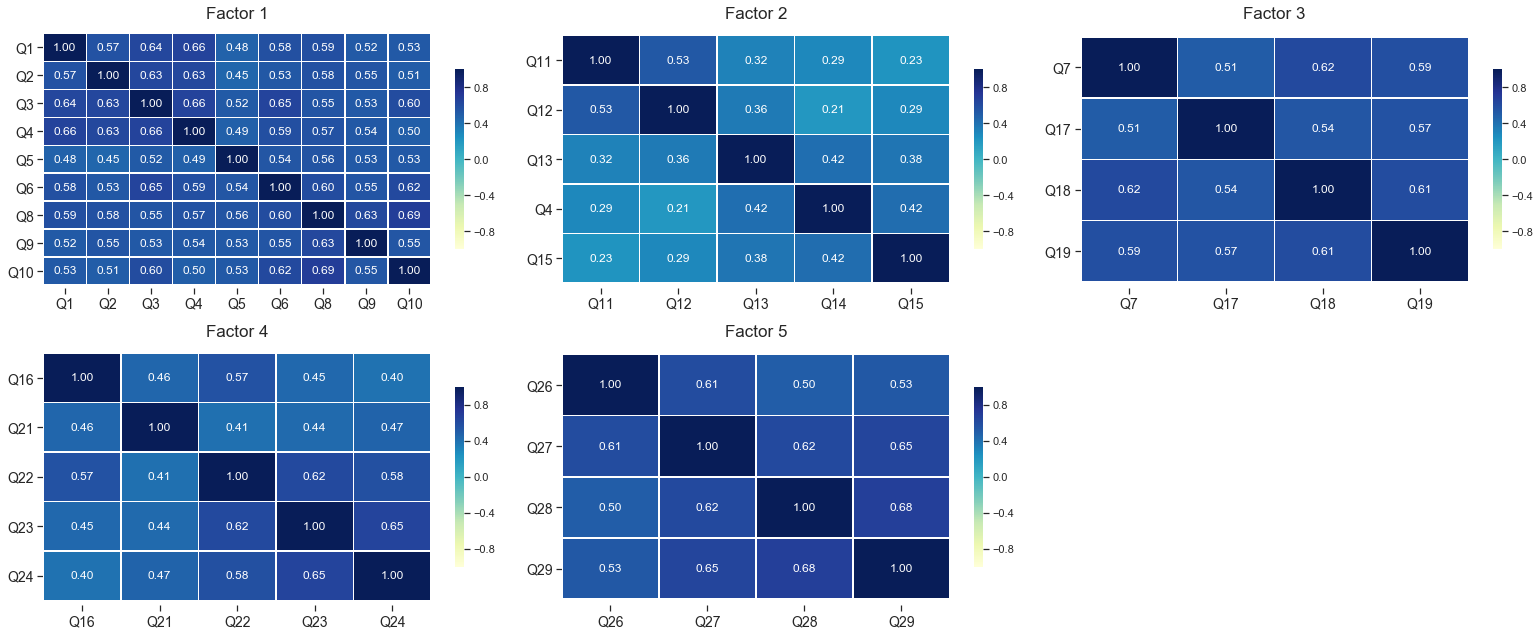

In [190]:
fig, ax = plt.subplots(figsize=(22,9)) 

plt.subplot(231)

heatmap1 = sns.heatmap(F1.corr(), vmin=-1, vmax=1, fmt='.2f',cmap="YlGnBu", cbar_kws={"shrink": .7}, square = False, linewidths=.5, annot=True)
heatmap1.set_title('Factor 1', fontdict={'fontsize':17}, pad=12)
bottom, top = heatmap1.get_ylim()
heatmap1.set_ylim(bottom + 0.6, top - 0.6)
heatmap1.set_yticklabels(labels = ['Q1','Q2','Q3','Q4', 'Q5', 'Q6', 'Q8', 'Q9', 'Q10'], rotation =0, size = 14)
heatmap1.set_xticklabels(labels = ['Q1','Q2','Q3','Q4', 'Q5', 'Q6', 'Q8', 'Q9', 'Q10'], rotation =0, size = 14)


plt.subplot(232)

heatmap3 = sns.heatmap(F2.corr(), vmin=-1, vmax=1, fmt='.2f', cmap="YlGnBu", cbar_kws={"shrink": .7}, square = False, linewidths=.5, annot=True)
heatmap3.set_title('Factor 2', fontdict={'fontsize':17}, pad=12)
bottom, top = heatmap3.get_ylim()
heatmap3.set_ylim(bottom + 0.6, top - 0.6)
heatmap3.set_yticklabels(labels = ['Q11','Q12','Q13','Q4', 'Q15'], rotation =0, size = 14)
heatmap3.set_xticklabels(labels = ['Q11','Q12','Q13','Q14', 'Q15'], rotation =0, size = 14)


plt.subplot(233)
heatmap4 = sns.heatmap(F3.corr(), vmin=-1, vmax=1, fmt='.2f', cbar_kws={"shrink": .7},cmap="YlGnBu", square = False, linewidths=.5, annot=True)
heatmap4.set_title('Factor 3', fontdict={'fontsize':17}, pad=12)

bottom, top = heatmap4.get_ylim()
heatmap4.set_ylim(bottom + 0.6, top - 0.6)
heatmap4.set_yticklabels(labels = ['Q7','Q17','Q18','Q19','Q20'], rotation =0, size = 14)
heatmap4.set_xticklabels(labels = ['Q7','Q17','Q18','Q19','Q20'], rotation =0, size = 14)


plt.subplot(234)
heatmap5 = sns.heatmap(F4.corr(), vmin=-1, vmax=1, fmt='.2f', cmap="YlGnBu", cbar_kws={"shrink": .7}, square = False, linewidths=.5, annot=True)
heatmap5.set_title('Factor 4', fontdict={'fontsize':17}, pad=12)
bottom, top = heatmap5.get_ylim()
heatmap5.set_ylim(bottom + 0.6, top - 0.6)
heatmap5.set_yticklabels(labels = ['Q16','Q21','Q22','Q23','Q24', 'Q25'], rotation =0, size = 14)
heatmap5.set_xticklabels(labels = ['Q16','Q21','Q22','Q23','Q24', 'Q25'], rotation =0, size = 14)
plt.subplot(235)

heatmap6 = sns.heatmap(F5.corr(), vmin=-1, vmax=1, fmt='.2f', cmap="YlGnBu", cbar_kws={"shrink": .7}, square = False, linewidths=.5, annot=True)
heatmap6.set_title('Factor 5', fontdict={'fontsize':17}, pad=12)
bottom, top = heatmap6.get_ylim()
heatmap6.set_ylim(bottom + 0.6, top - 0.6)
heatmap6.set_yticklabels(labels = ['Q26','Q27','Q28','Q29'], rotation =0, size = 14)
heatmap6.set_xticklabels(labels = ['Q26','Q27','Q28','Q29'], rotation =0, size = 14)

plt.tight_layout()

In [58]:
csv_download_link(scalerpd, 'rescaled_newX.csv')


C:\Users\maria\Dropbox\datos\SERIAL_DEPENDENCE_COOL\Untitled Folder\rescaled_newX.csv

Press enter to delete the file after you have downloaded it.


<a href='#inicio'> Ir a inicio </a>